In [1]:
from prody import *
import numpy as np
import prody
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from math import acos,asin, degrees
from prody.measure.measure import getAngle

In [2]:
sns.set_context("talk")
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Set2.colors)
plt.rcParams.update({'font.size': 22})
plt.rcParams['svg.fonttype'] = 'none'

In [3]:
pdb_info = pd.read_csv("NR_H_Protein_Martin_info.csv")
Dirname = "../AnnotatedStructures/NR_H_Protein_Martin"

In [4]:
t = parsePDB(os.path.join(Dirname,"4KML_1.pdb"))

@> 1823 atoms and 1 coordinate set(s) were parsed in 0.02s.


In [106]:
t.select("chain H resnum 100G ca").getResnames()

array(['TYR'], dtype='<U6')

In [18]:
t.getResnums()

array([  1,   1,   1, ..., 225, 225, 225])

In [22]:
t.select("chain H resnum 100G ca").ca.getResnums()

array([100])

In [ ]:
t.getIcodes()

In [ ]:
t.select("chain H resnum 100G ca").ca.getResnums()

In [23]:
t.select("chain H resnum 100G ca").ca.getIcodes()

array(['G'], dtype='<U1')

In [4]:
def getResdiueAhead101(structure):
    selection100 = structure['H'].select("resnum 100")
    if selection100==None:
        return None
    else:
        icodes = selection100.getIcodes()
        return f"100{icodes[-1]}"

In [5]:
'''
calculate the normal vector of a plane given 3 points
'''
def calcPlaneVec(coord1,coord2,coord3):
    v1 = coord3-coord1
    v2 = coord2-coord1
    normal_vec = np.cross(v1,v2)
    return normal_vec
'''
calculate the vector of a line given 2 points
'''
def calcLineVec(coord1,coord2):
    return coord2-coord1

'''
calculate the sin between line and plane
'''
def calcPlaneLineAngle(plane_vec,line_vec):
    sin_phi = abs(plane_vec@line_vec/(np.sqrt(np.sum(plane_vec**2))*np.sqrt(np.sum(line_vec**2))))
    angle = degrees(asin(sin_phi))
    return angle,sin_phi
'''
Input:
    selection of a charged atom
    selection of atoms forming a atomatic ring
Return:
    Distance between charged atom and the centroid of the ring
    The sin of dihedral angle 
    Projected distance between charged atom and the centroid of the ring
'''
def calcPoint2Ring(point_selection,ring_selection):
    point_coord = point_selection.getCoords()[0]
    ring_coords = ring_selection.getCoords()
    
    centroid_ring_coord = ring_coords.mean(0)
    dist2centroid = calcDistance(point_coord,centroid_ring_coord)
    
    line_vec = calcLineVec(point_coord,centroid_ring_coord)
    plane_vec = calcPlaneVec(*ring_coords[:3,:])
    angle,sin_phi = calcPlaneLineAngle(plane_vec,line_vec)
    dist2centroid_projection = sin_phi *dist2centroid
    
    return (dist2centroid,angle,dist2centroid_projection)

def calcRing2Ring(ring_selection_1,ring_selection_2):
    ring_coords_1 = ring_selection_1.getCoords()
    ring_coords_2 = ring_selection_2.getCoords()
    centroid_ring_coord_1 = ring_coords_1.mean(0)
    centroid_ring_coord_2 = ring_coords_2.mean(0)
    dist2centroid = calcDistance(centroid_ring_coord_1,centroid_ring_coord_2)
    
    #line_vec_ = calcLineVec(point_coord,centroid_ring_coord)

    plane_vec_1 = calcPlaneVec(*ring_coords_1[:3,:])
    plane_vec_2 = calcPlaneVec(*ring_coords_2[:3,:])
    angle,sin_phi = calcPlaneLineAngle(plane_vec_1,plane_vec_2)
    dist2centroid_projection = sin_phi *dist2centroid
    
    return (dist2centroid,angle,dist2centroid_projection)
    
    
    
    

In [6]:
ATOM_NAMES=dict()
ATOM_NAMES['TRP'] = "CD2 CE2 CE3 CZ2 CZ3 CH2"
ATOM_NAMES['TYR'] = "CG CD1 CD2 CE1 CE2 CZ"
ATOM_NAMES['PHE'] = "CG CD1 CD2 CE1 CE2 CZ"
ATOM_NAMES['LYS'] = "NZ"
ATOM_NAMES['ARG'] ="NH1"

## R45 and W103

In [10]:
data=[]
num_low_res=0
for idx,row in pdb_info.iterrows():
    reso = row['resolution']
    if reso>3:
        num_low_res+=1
        continue
    pdb_name = row['pdb']
    structure = parsePDB(os.path.join(Dirname,pdb_name))
    AA45 = structure.select("chain H resnum 45 ca").getResnames()[0]
    AA103 = structure.select("chain H resnum 103 ca").getResnames()[0]
    if not (AA45 in ("ARG","LYS") and  AA103 in ("TRP","TYR","PHE")):
        continue
    AA45_charge = structure.select(f"resnum 45 name {ATOM_NAMES[AA45]} chain H")
    AA103_ring = structure.select(f"resnum 103 name {ATOM_NAMES[AA103]} chain H")
    
    distance, angle,projection_dist = calcPoint2Ring(AA45_charge,AA103_ring)
    data.append((pdb_name,reso,AA45,AA103,distance,angle,projection_dist))

@> 1938 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 1879 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 1828 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 2040 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 6128 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 3052 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 3585 atoms and 1 coordinate set(s) were parsed in 0.04s.
@> 1659 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 1810 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 1142 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> 1830 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 5796 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 2178 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 5810 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 1901 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 1715 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 2968 atoms and 1 coordinate set(s) we

AttributeError: 'NoneType' object has no attribute 'getResnames'

In [11]:
AA45_AA103 = pd.DataFrame(data,columns=['pdb','resolution','AA45','AA103','Distance','Angle','ProjectedDistance'])

In [12]:
AA45_AA103

,pdb,resolution,AA45,AA103,Distance,Angle,ProjectedDistance
0,1ZMY_1.pdb,3.00,ARG,TRP,3.485887,66.307358,3.192076
1,5JDS_1.pdb,1.70,ARG,TRP,3.766059,58.260972,3.202856
2,3QSK_1.pdb,1.75,ARG,TRP,3.339473,83.033411,3.314817
3,4NBZ_1.pdb,1.75,ARG,TRP,5.729496,74.383029,5.517980
4,4LGS_1.pdb,2.70,ARG,TRP,5.238037,68.409758,4.870532
...,...,...,...,...,...,...,...
91,5BOP_1.pdb,1.95,ARG,TRP,3.809991,53.959258,3.080755
92,4LHQ_1.pdb,2.30,ARG,TRP,4.739042,38.551146,2.953433
93,4LHJ_1.pdb,1.80,ARG,TRP,3.865698,75.938022,3.749856
94,5HM1_1.pdb,2.96,ARG,TRP,3.704272,58.884897,3.171342


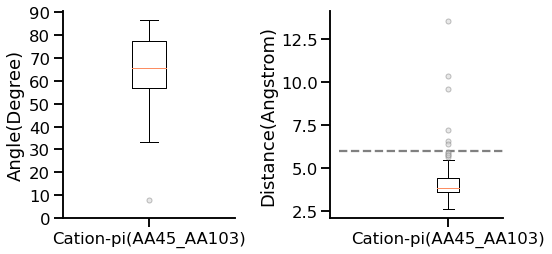

In [214]:
fig,axes = plt.subplots(nrows=1,ncols=2,figsize=(8,4))
axes[0].boxplot([AA45_AA103['Angle']],widths=[0.2],flierprops=flierprops)
axes[0].set_ylabel('Angle(Degree)')
axes[0].set_xticklabels(['Cation-pi(AA45_AA103)'])
axes[0].set_yticks(np.arange(0,91,10))
axes[1].boxplot([AA45_AA103['Distance']],widths=[0.2],flierprops=flierprops)
axes[1].set_ylabel('Distance(Angstrom)')
axes[1].set_xticklabels(['Cation-pi(AA45_AA103)'])
axes[1].hlines(xmin=0,xmax=1.5,y=6,linestyle="dashed",color='gray')
sns.despine()
fig.tight_layout()
plt.savefig("Angles_Distance_cation_pi.svg",format='svg')

## F/Y47 and Y100X

In [160]:
pi_pi_data=[]
for idx,row in pdb_info.iterrows():
    reso = row['resolution']
    if reso>3:
        continue
    pdb_name = row['pdb']
    structure = parsePDB(os.path.join(Dirname,pdb_name))
    AA37 = structure.select("chain H resnum 37 ca").getResnames()[0]
    resnum100X = getResdiueAhead101(structure)
    if resnum100X==None:
        continue
    AA100X = structure.select(f"chain H resnum {resnum100X} ca").getResnames()[0]
    if not (AA37 in ("TRP","TYR","PHE") and  AA100X in ("TRP","TYR","PHE")):
        continue
    AA37_ring = structure.select(f"resnum 45 name {ATOM_NAMES[AA37]} chain H")
    AA100X_ring= structure.select(f"resnum {resnum100X} name {ATOM_NAMES[AA100X]} chain H")
    distance, angle,projection_dist = calcPoint2Ring(AA37_ring,AA100X_ring)
    pi_pi_data.append((pdb_name,reso,AA37,AA100X,distance,angle,projection_dist))

@> 1938 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 1879 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 1828 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 2040 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 6128 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 3052 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 3585 atoms and 1 coordinate set(s) were parsed in 0.04s.
@> 1659 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 1810 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 1142 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> 1830 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 5796 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 2178 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 5810 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 1901 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 1715 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2968 atoms and 1 coordinate set(s) we

AttributeError: 'NoneType' object has no attribute 'getCoords'

In [181]:
AA37_AA100X = pd.DataFrame(pi_pi_data,columns=['pdb','resolution','AA37','AA100X','Distance','Angle','ProjectedDistance'])

# F/Y47 and W103

In [172]:
data=[]
for idx,row in pdb_info.iterrows():
    reso = row['resolution']
    if reso>3:
        continue
    pdb_name = row['pdb']
    structure = parsePDB(os.path.join(Dirname,pdb_name))
    AA37 = structure.select("chain H resnum 37 ca").getResnames()[0]
    AA103 = structure.select("chain H resnum 103 ca").getResnames()[0]
    if not (AA37 in ("TRP","TYR","PHE") and  AA103 in ("TRP","TYR","PHE")):
        continue
    AA37_ring = structure.select(f"resnum 37 name {ATOM_NAMES[AA37]} chain H")
    AA103_ring = structure.select(f"resnum 103 name {ATOM_NAMES[AA103]} chain H")
    
    distance, angle,projection_dist = calcRing2Ring(AA37_ring,AA103_ring)
    data.append((pdb_name,reso,AA37,AA103,distance,angle,projection_dist))

@> 1938 atoms and 1 coordinate set(s) were parsed in 0.04s.
@> 1879 atoms and 1 coordinate set(s) were parsed in 0.04s.
@> 1828 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2040 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 6128 atoms and 1 coordinate set(s) were parsed in 0.07s.
@> 3052 atoms and 1 coordinate set(s) were parsed in 0.04s.
@> 3585 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 1659 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 1810 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 1142 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 1830 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 5796 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 2178 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 5810 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 1901 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 1715 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 2968 atoms and 1 coordinate set(s) we

@> 3325 atoms and 1 coordinate set(s) were parsed in 0.04s.
@> 3344 atoms and 1 coordinate set(s) were parsed in 0.04s.
@> 3226 atoms and 1 coordinate set(s) were parsed in 0.04s.
@> 1922 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 1956 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 3022 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 2996 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 4277 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 3250 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 2651 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 8676 atoms and 1 coordinate set(s) were parsed in 0.08s.
@> 1541 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 1746 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 1650 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 1964 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 3392 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 1678 atoms and 1 coordinate set(s) we

In [173]:
AA37_AA103 = pd.DataFrame(data,columns=['pdb','resolution','AA37','AA100X','Distance','Angle','ProjectedDistance'])

In [196]:
flierprops = dict(marker='o', markerfacecolor='lightgrey', markersize=5, linestyle='none',linewidth=0,markeredgecolor='grey',alpha=0.5)

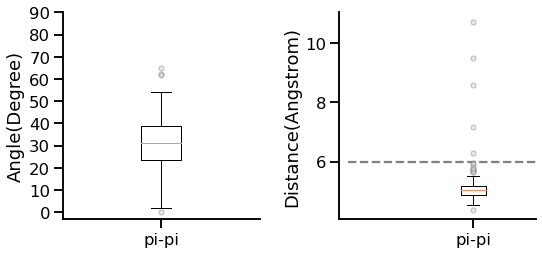

In [215]:
fig = plt.figure(figsize=(8,4))
ax1 = fig.add_subplot(121)
ax1.boxplot([AA37_AA103['Angle']],widths=[0.2],flierprops=flierprops)
ax1.set_ylabel('Angle(Degree)')
ax1.set_xticklabels(['pi-pi'])
ax1.set_yticks(np.arange(0,91,10))

ax2 = fig.add_subplot(122)
ax2.boxplot([AA37_AA103['Distance']],widths=[0.2],flierprops=flierprops)
ax2.set_ylabel('Distance(Angstrom)')
ax2.set_xticklabels(['pi-pi'])
ax2.hlines(xmin=0,xmax=1.5,y=6,linestyle="dashed",color='gray')
sns.despine()
fig.tight_layout()
plt.savefig("Angles_Distance_pi_pi_37_103.svg",format='svg')

In [187]:
AA45_AA103['Distance'].mean()

4.324483411307489

## Cys-Cys

In [52]:
data=[]
cdr3_lens  = []
for idx,row in pdb_info.iterrows():
    reso = row['resolution']
    if reso>3:
        continue
    pdb_name = row['pdb']
    print(pdb_name)
    structure = parsePDB(os.path.join(Dirname,pdb_name))
    cdr12_cys=[]
    cdr1_selection = structure.select("chain H resnum 26 to 35").copy()
    cdr2_selection = structure.select("chain H resnum 50 to 58").copy()
    cdr3_selection = structure.select("chain H resnum 94 to 102").copy()
    cdr3_cys=[]
    cdr3_len = len(cdr3_selection.ca.getResnames())
    cdr3_lens.append(cdr3_len)
    print("CDR1")
    for aa in cdr1_selection.ca:
        if aa.getResname() == "CYS":
            resnum = str(aa.getResnum())+aa.getIcode()
            print(resnum)
            cdr12_cys.append(resnum)
    print("CDR2")
    for aa in cdr2_selection.ca:
        if aa.getResname() == "CYS":
            resnum = str(aa.getResnum())+aa.getIcode()
            print(resnum)
            cdr12_cys.append(resnum)
    print("CDR3")
    for aa in cdr3_selection.ca:
        if aa.getResname() == "CYS":
            resnum = str(aa.getResnum())+aa.getIcode()
            print(resnum)
            cdr3_cys.append(resnum)
    dists = [100]
    for aa_cdr12_cys in cdr12_cys:
        for aa_cdr3_cys in cdr3_cys:
            AA_CDR1_CYS = structure.select(f"resnum {aa_cdr12_cys} name SG chain H")
            AA_CDR3_CYS = structure.select(f"resnum {aa_cdr3_cys} name SG chain H")
            distance = calcDistance(AA_CDR1_CYS,AA_CDR3_CYS)[0]
            dists.append(distance)
    data.append(np.min(dists))
    #AA37 = structure.select("chain H resnum 37 ca").getResnames()[0]
    #AA103 = structure.select("chain H resnum 103 ca").getResnames()[0]
    #if not (AA37 in ("TRP","TYR","PHE") and  AA103 in ("TRP","TYR","PHE")):
    #    continue
    #AA37_ring = structure.select(f"resnum 37 name {ATOM_NAMES[AA37]} chain H")
    #AA103_ring = structure.select(f"resnum 103 name {ATOM_NAMES[AA103]} chain H")
    
    
    #data.append((pdb_name,reso,AA37,AA103,distance,angle,projection_dist))

@> 1938 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 1879 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 1828 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2040 atoms and 1 coordinate set(s) were parsed in 0.02s.


1ZMY_1.pdb
CDR1
33
CDR2
CDR3
100E
5JDS_1.pdb
CDR1
33
CDR2
CDR3
100B
3QSK_1.pdb
CDR1
CDR2
CDR3
4NBZ_1.pdb
CDR1
CDR2
CDR3
5USF_1.pdb


@> 6128 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 3052 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 3585 atoms and 1 coordinate set(s) were parsed in 0.04s.
@> 1659 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 1810 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 1142 atoms and 1 coordinate set(s) were parsed in 0.02s.


CDR1
CDR2
CDR3
4LGS_1.pdb
CDR1
CDR2
CDR3
4OCN_2.pdb
CDR1
CDR2
CDR3
3K80_1.pdb
CDR1
CDR2
CDR3
4N9O_1.pdb
CDR1
CDR2
CDR3
6J7W_1.pdb
CDR1
CDR2
CDR3
2P49_1.pdb


@> 1830 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 5796 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 2178 atoms and 1 coordinate set(s) were parsed in 0.03s.


CDR1
CDR2
CDR3
6H6Y_1.pdb
CDR1
CDR2
CDR3
3CFI_1.pdb
CDR1
CDR2
CDR3
6H15_1.pdb


@> 5810 atoms and 1 coordinate set(s) were parsed in 0.07s.
@> 1901 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 1715 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2968 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 3551 atoms and 1 coordinate set(s) were parsed in 0.04s.
@> 2091 atoms and 1 coordinate set(s) were parsed in 0.03s.


CDR1
CDR2
CDR3
3EBA_1.pdb
CDR1
CDR2
CDR3
5JA9_1.pdb
CDR1
CDR2
CDR3
4N1H_1.pdb
CDR1
CDR2
CDR3
4OCN_1.pdb
CDR1
CDR2
CDR3
4NBX_1.pdb


@> 3804 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 2758 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 3990 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 1886 atoms and 1 coordinate set(s) were parsed in 0.02s.


CDR1
CDR2
CDR3
5M14_2.pdb
CDR1
CDR2
CDR3
4TVS_1.pdb
CDR1
CDR2
CDR3
5F7K_1.pdb
CDR1
CDR2
CDR3
1RI8_1.pdb
CDR1

@> 1842 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 3073 atoms and 1 coordinate set(s) were parsed in 0.04s.
@> 3218 atoms and 1 coordinate set(s) were parsed in 0.04s.



33
CDR2
CDR3
100B
4U3X_1.pdb
CDR1
CDR2
CDR3
6H70_1.pdb
CDR1
CDR2
CDR3
5OMN_1.pdb
CDR1
CDR2
CDR3
6C9W_1.pdb


@> 8118 atoms and 1 coordinate set(s) were parsed in 0.08s.
@> 3732 atoms and 1 coordinate set(s) were parsed in 0.04s.
@> 5109 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 1741 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 4929 atoms and 1 coordinate set(s) were parsed in 0.05s.


CDR1
CDR2
CDR3
3ZKQ_1.pdb
CDR1
CDR2
CDR3
5MY6_1.pdb
CDR1
32
CDR2
CDR3
95
2X89_1.pdb
CDR1
33
CDR2
CDR3
100
5FOJ_1.pdb
CDR1
CDR2
CDR3
3STB_1.pdb


@> 1767 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 4165 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 3058 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 4459 atoms and 1 coordinate set(s) were parsed in 0.04s.
@> 1818 atoms and 1 coordinate set(s) were parsed in 0.02s.


CDR1
CDR2
CDR3
5HVH_1.pdb
CDR1
CDR2
CDR3
6H72_1.pdb
CDR1
CDR2
CDR3
6MXT_1.pdb
CDR1
CDR2
CDR3
5G5R_1.pdb
CDR1
CDR2
CDR3
6GKD_1.pdb


@> 4020 atoms and 1 coordinate set(s) were parsed in 0.04s.
@> 1813 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 3700 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 2958 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 1994 atoms and 1 coordinate set(s) were parsed in 0.02s.


CDR1
CDR2
CDR3
5JA8_1.pdb
CDR1
CDR2
50
CDR3
98
5C2U_1.pdb
CDR1
CDR2
CDR3
5F1O_1.pdb
CDR1
CDR2
CDR3
4P2C_1.pdb
CDR1
CDR2
CDR3
4LAJ_1.pdb


@> 6249 atoms and 1 coordinate set(s) were parsed in 0.07s.
@> 2369 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 3800 atoms and 1 coordinate set(s) were parsed in 0.04s.
@> 2949 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 5890 atoms and 1 coordinate set(s) were parsed in 0.06s.


CDR1
CDR2
50
CDR3
96
6GJQ_1.pdb
CDR1
CDR2
CDR3
5M15_2.pdb
CDR1
CDR2
CDR3
4LGP_1.pdb
CDR1
CDR2
50
CDR3
96
5VXL_1.pdb
CDR1
CDR2
CDR3
4LGR_1.pdb


@> 2893 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 3707 atoms and 1 coordinate set(s) were parsed in 0.04s.
@> 1865 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 1729 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2342 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 1625 atoms and 1 coordinate set(s) were parsed in 0.02s.


CDR1
35
CDR2
CDR3
5F7L_1.pdb
CDR1
CDR2
CDR3
100B
100E
4ORZ_1.pdb
CDR1
CDR2
CDR3
3P9W_1.pdb
CDR1
CDR2
CDR3
4OCM_1.pdb
CDR1
CDR2
CDR3
5N88_1.pdb
CDR1
CDR2
CDR3
5U4L_1.pdb


@> 3007 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 2955 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 5726 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 2712 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 1826 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 1440 atoms and 1 coordinate set(s) were parsed in 0.02s.


CDR1
CDR2
CDR3
2WZP_1.pdb
CDR1
33
CDR2
CDR3
6H16_1.pdb
CDR1
CDR2
CDR3
6F5G_1.pdb
CDR1
CDR2
CDR3
4POU_1.pdb
CDR1
CDR2
CDR3
4W2Q_2.pdb


@> 2068 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 1824 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 4551 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 1715 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 1852 atoms and 1 coordinate set(s) were parsed in 0.02s.


CDR1
CDR2
CDR3
5DMJ_1.pdb
CDR1
CDR2
CDR3
1ZV5_1.pdb
CDR1
33
CDR2
CDR3
100B
4KRM_1.pdb
CDR1
CDR2
CDR3
5E5M_1.pdb
CDR1
CDR2
CDR3
2P4A_1.pdb
CDR1
CDR2
CDR3
5MWN_2.pdb


@> 5690 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 1944 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2448 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 5439 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 5865 atoms and 1 coordinate set(s) were parsed in 0.06s.


CDR1
CDR2
CDR3
4NC2_1.pdb
CDR1
CDR2
CDR3
4QO1_1.pdb
CDR1
CDR2
CDR3
5VNW_1.pdb
CDR1
CDR2
CDR3
5VXJ_3.pdb
CDR1
CDR2
CDR3
6H7N_1.pdb


@> 3223 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 3312 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 4827 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 3046 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 2133 atoms and 1 coordinate set(s) were parsed in 0.02s.


CDR1
CDR2
CDR3
5MWN_1.pdb
CDR1
CDR2
CDR3
5F1K_1.pdb
CDR1
CDR2
CDR3
6FV0_1.pdb
CDR1
CDR2
CDR3
5M2M_1.pdb
CDR1
CDR2
CDR3
6EY0_1.pdb


@> 2139 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 4006 atoms and 1 coordinate set(s) were parsed in 0.04s.
@> 2272 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 4542 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 3230 atoms and 1 coordinate set(s) were parsed in 0.03s.


CDR1
CDR2
CDR3
6IBL_1.pdb
CDR1
CDR2
CDR3
5SV3_1.pdb
CDR1
CDR2
CDR3
6GS4_1.pdb
CDR1
CDR2
CDR3
4X7C_2.pdb
CDR1
CDR2
CDR3
5O03_1.pdb


@> 3307 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 2967 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 2308 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 2335 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 3738 atoms and 1 coordinate set(s) were parsed in 0.04s.


CDR1
CDR2
50
CDR3
100C
5LWF_1.pdb
CDR1
CDR2
CDR3
6FYU_1.pdb
CDR1
CDR2
CDR3
4IOS_2.pdb
CDR1
CDR2
CDR3
5O0W_1.pdb
CDR1
CDR2
50
CDR3
100I
5JMO_1.pdb


@> 4449 atoms and 1 coordinate set(s) were parsed in 0.04s.
@> 3749 atoms and 1 coordinate set(s) were parsed in 0.04s.
@> 1416 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2361 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 3461 atoms and 1 coordinate set(s) were parsed in 0.05s.


CDR1
CDR2
CDR3
5FUC_2.pdb
CDR1
33
CDR2
CDR3
100
6FE4_1.pdb
CDR1
CDR2
CDR3
6GK4_1.pdb
CDR1
CDR2
CDR3
6B20_1.pdb
CDR1
CDR2
CDR3
3RJQ_1.pdb


@> 3278 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 3202 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 3331 atoms and 1 coordinate set(s) were parsed in 0.04s.
@> 2428 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 2877 atoms and 1 coordinate set(s) were parsed in 0.03s.


CDR1
CDR2
CDR3
4X7C_1.pdb
CDR1
CDR2
CDR3
5O03_2.pdb
CDR1
CDR2
50
CDR3
100D
3EZJ_1.pdb
CDR1
CDR2
CDR3
4HEM_1.pdb
CDR1
CDR2
CDR3
4IOS_1.pdb


@> 2299 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 2109 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2749 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 2724 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 4183 atoms and 1 coordinate set(s) were parsed in 0.05s.


CDR1
CDR2
CDR3
4EIG_1.pdb
CDR1
CDR2
CDR3
4WEN_1.pdb
CDR1
CDR2
CDR3
4WEU_1.pdb
CDR1
CDR2
CDR3
6F2G_1.pdb
CDR1
CDR2
CDR3
3K74_1.pdb


@> 2149 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 3756 atoms and 1 coordinate set(s) were parsed in 0.04s.
@> 2751 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 1427 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2372 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 1890 atoms and 1 coordinate set(s) were parsed in 0.02s.


CDR1
CDR2
CDR3
5FUC_1.pdb
CDR1
33
CDR2
CDR3
100
3G9A_1.pdb
CDR1
CDR2
CDR3
100J
4GFT_1.pdb
CDR1
CDR2
CDR3
6R7T_1.pdb
CDR1
CDR2
CDR3
1ZVY_1.pdb
CDR1
CDR2
CDR3
4CDG_1.pdb


@> 5822 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 2295 atoms and 1 coordinate set(s) were parsed in 0.04s.
@> 11304 atoms and 1 coordinate set(s) were parsed in 0.13s.


CDR1
CDR2
CDR3
4DKA_2.pdb
CDR1
CDR2
CDR3
3V0A_1.pdb
CDR1
CDR2
CDR3
5C1M_1.pdb


@> 3234 atoms and 1 coordinate set(s) were parsed in 0.04s.
@> 3225 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 4066 atoms and 1 coordinate set(s) were parsed in 0.04s.
@> 4453 atoms and 1 coordinate set(s) were parsed in 0.04s.
@> 3804 atoms and 1 coordinate set(s) were parsed in 0.04s.


CDR1
CDR2
CDR3
5O05_1.pdb
CDR1
CDR2
CDR3
6EY6_1.pdb
CDR1
CDR2
CDR3
5VAK_1.pdb
CDR1
CDR2
CDR3
5NBL_1.pdb
CDR1
CDR2
CDR3
4EJ1_1.pdb


@> 2225 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 2229 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 1431 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 5024 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 2296 atoms and 1 coordinate set(s) were parsed in 0.03s.


CDR1
CDR2
CDR3
4I1N_1.pdb
CDR1
CDR2
CDR3
5O2U_1.pdb
CDR1
CDR2
CDR3
5J1T_1.pdb
CDR1
CDR2
CDR3
5BOP_1.pdb
CDR1
CDR2
CDR3
4LHQ_1.pdb


@> 3029 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 2943 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 1029 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> 2236 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 3012 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 1522 atoms and 1 coordinate set(s) were parsed in 0.02s.


CDR1
CDR2
CDR3
4LHJ_1.pdb
CDR1
CDR2
CDR3
5HM1_1.pdb
CDR1
CDR2
CDR3
4I13_1.pdb
CDR1
CDR2
CDR3
5J57_1.pdb
CDR1
CDR2
50
CDR3
100E
2XT1_1.pdb
CDR1
CDR2
CDR3
5M2I_1.pdb


@> 3218 atoms and 1 coordinate set(s) were parsed in 0.04s.
@> 2855 atoms and 1 coordinate set(s) were parsed in 0.04s.
@> 8151 atoms and 1 coordinate set(s) were parsed in 0.08s.
@> 1945 atoms and 1 coordinate set(s) were parsed in 0.02s.


CDR1
CDR2
CDR3
5F21_1.pdb
CDR1
CDR2
CDR3
6EHG_1.pdb
CDR1
CDR2
CDR3
1OP9_1.pdb
CDR1
CDR2
CDR3
4GRW_3.pdb


@> 3269 atoms and 1 coordinate set(s) were parsed in 0.04s.
@> 7912 atoms and 1 coordinate set(s) were parsed in 0.08s.
@> 7731 atoms and 1 coordinate set(s) were parsed in 0.07s.


CDR1
CDR2
CDR3
5C3L_1.pdb
CDR1
CDR2
CDR3
5VAN_1.pdb
CDR1
CDR2
CDR3
3K1K_1.pdb


@> 2641 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 2851 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 1837 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 3848 atoms and 1 coordinate set(s) were parsed in 0.04s.
@> 2748 atoms and 1 coordinate set(s) were parsed in 0.03s.


CDR1
CDR2
CDR3
6NBF_1.pdb
CDR1
CDR2
CDR3
95
100C
2P43_1.pdb
CDR1
CDR2
CDR3
5IMM_1.pdb
CDR1
CDR2
CDR3
4WEM_1.pdb
CDR1
CDR2
CDR3
5HVF_1.pdb


@> 3918 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 2336 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 3325 atoms and 1 coordinate set(s) were parsed in 0.04s.
@> 3344 atoms and 1 coordinate set(s) were parsed in 0.04s.
@> 3226 atoms and 1 coordinate set(s) were parsed in 0.04s.


CDR1
CDR2
CDR3
6FYT_1.pdb
CDR1
CDR2
CDR3
5O02_1.pdb
CDR1
CDR2
CDR3
6DO1_1.pdb
CDR1
CDR2
CDR3
4XT1_1.pdb


@> 1922 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 1956 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 3022 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 2996 atoms and 1 coordinate set(s) were parsed in 0.04s.


CDR1
CDR2
CDR3
5E7F_1.pdb
CDR1
CDR2
CDR3
100H
4GRW_1.pdb
CDR1
CDR2
50
CDR3
98
6CWG_1.pdb
CDR1
CDR2
52A
CDR3
99
5J56_1.pdb
CDR1
CDR2
CDR3
5E0Q_1.pdb


@> 4277 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 3250 atoms and 1 coordinate set(s) were parsed in 0.04s.
@> 2651 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 8676 atoms and 1 coordinate set(s) were parsed in 0.08s.


CDR1
CDR2
CDR3
5O04_2.pdb
CDR1
CDR2
CDR3
6I6J_1.pdb
CDR1
CDR2
CDR3
1KXV_1.pdb
CDR1
30
CDR2
CDR3
100C
1MVF_2.pdb


@> 1541 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 1746 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 1650 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 1964 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 3392 atoms and 1 coordinate set(s) were parsed in 0.04s.
@> 1678 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 1599 atoms and 1 coordinate set(s) were parsed in 0.02s.


CDR1
CDR2
CDR3
6H1F_1.pdb
CDR1
CDR2
CDR3
2VYR_4.pdb
CDR1
CDR2
CDR3
5M2J_1.pdb
CDR1
CDR2
CDR3
5Y80_1.pdb
CDR1
CDR2
CDR3
3K7U_1.pdb
CDR1
CDR2
CDR3
1MVF_1.pdb
CDR1
CDR2
CDR3
5LHR_1.pdb


@> 2802 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 2463 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 1823 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 7708 atoms and 1 coordinate set(s) were parsed in 0.09s.


CDR1
CDR2
CDR3
5MP2_1.pdb
CDR1
CDR2
CDR3
4KML_1.pdb
CDR1
CDR2
CDR3
5VAQ_1.pdb
CDR1
CDR2
CDR3
4X7F_1.pdb


@> 3204 atoms and 1 coordinate set(s) were parsed in 0.04s.


CDR1
CDR2
CDR3


(array([17.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([2.02320884, 2.10651901, 2.18982918, 2.27313935, 2.35644953,
        2.4397597 , 2.52306987, 2.60638004, 2.68969021, 2.77300039,
        2.85631056]),
 <BarContainer object of 10 artists>)

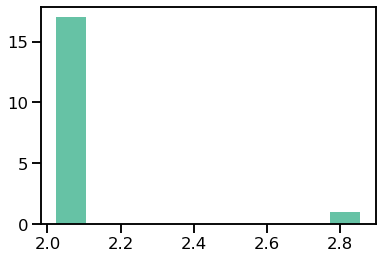

In [53]:
plt.hist([i for i in data if i!=100])

In [58]:
len([(i,j) for i,j in zip(data,cdr3_lens) if i<2.2])

17

In [59]:
[(i,j) for i,j in zip(data,cdr3_lens) if i<2.2]

[(2.0321262263944107, 20),
 (2.0309591330206507, 18),
 (2.053288338251598, 8),
 (2.0253446620266886, 20),
 (2.0343986826578373, 13),
 (2.0367879123757553, 15),
 (2.023208837465871, 9),
 (2.0333956821041994, 13),
 (2.048106198418432, 24),
 (2.0439486294914833, 25),
 (2.051079228113829, 17),
 (2.048036132493764, 25),
 (2.047107960025555, 17),
 (2.023760114242792, 18),
 (2.057078997024664, 18),
 (2.029004928530238, 19),
 (2.0728229543306416, 14)]

In [74]:
def length_class(x):
    if x<5:
        return "<5"
    elif x<10:
        return "5~10"
    elif x<15:
        return "10~15"
    elif x<20:
        return "15~20"
    else:
        return ">20"

In [71]:
disulfide_cdr3_len = pd.DataFrame(list(zip([int(i<2.2) for i in data],cdr3_lens)),columns=['disulfide','cdr3 length'])

In [75]:
disulfide_cdr3_len['length group'] = disulfide_cdr3_len['cdr3 length'].apply(lambda x: length_class(x))

No handles with labels found to put in legend.


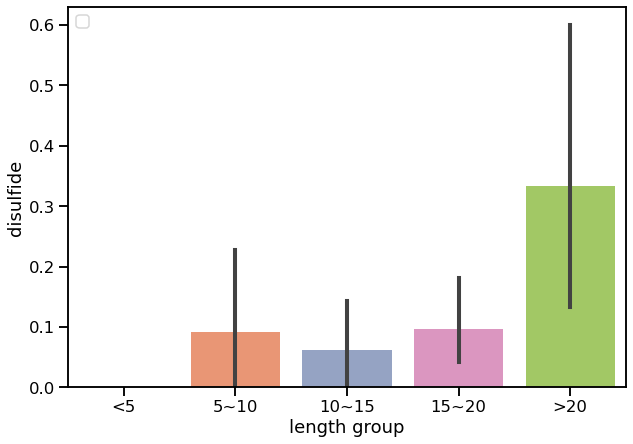

In [77]:
fig,axes = plt.subplots(1,1,figsize=(10,7))
sns.barplot(x='length group',y='disulfide',data=disulfide_cdr3_len,ax=axes,order=['<5','5~10','10~15','15~20','>20'])
plt.legend(loc="upper left")